In [14]:
import os
import shutil
import cv2
import numpy as np
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
from imutils import paths
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [15]:
# define the base path to the input dataset and then use it to derive
# the path to the input images and annotation CSV files
BASE_PATH = "VOC2012"
IMAGES_PATH = os.path.sep.join([BASE_PATH, "JPEGimages"])
IMAGES_PATH_REDUCED = os.path.sep.join([BASE_PATH, "Images_Reduced"])
ANNOTS_PATH = os.path.sep.join([BASE_PATH, "Annotations"])
ANNOTS_PATH_REDUCED = os.path.sep.join([BASE_PATH, "Annotations_Reduced"])

# define the path to the base output directory
BASE_OUTPUT = "output"
os.makedirs(BASE_OUTPUT, exist_ok=True)
# define the path to the output model, label encoder, plots output
# directory, and testing image paths
MODEL_PATH = os.path.sep.join([BASE_OUTPUT, "detector.pth"])
LE_PATH = os.path.sep.join([BASE_OUTPUT, "le.pickle"])
PLOTS_PATH = os.path.sep.join([BASE_OUTPUT, "plots"])
os.makedirs(PLOTS_PATH, exist_ok=True)
TEST_PATHS = os.path.sep.join([BASE_OUTPUT, "test_paths.txt"])

Below we are going to preprocess the data in a way that we have the two datasets we need. First, the whole dataset with images with several objects and parts and other with the images with only one object and one part in it. This is done because the Pytorch architecture only works with one object per image, but YOLO handles multiple objects.

In [16]:
def has_single_bounding_box(object_element):
    # Check if an object has only one bounding box (ignoring parts)
    return len(object_element.findall('part')) == 0

def filter_annotations(input_folder_annotations, output_folder_annotations, input_folder_images, output_folder_images, limit_number = 10000):
    os.makedirs(output_folder_annotations, exist_ok=True)
    os.makedirs(output_folder_images, exist_ok=True)
    count = 0
    for filename in os.listdir(input_folder_annotations):
        if count >= limit_number:
            continue
        if filename.endswith(".xml"):
            xml_path = os.path.join(input_folder_annotations, filename)
            tree = ET.parse(xml_path)
            root = tree.getroot()

            # Check if the annotation has only one object with a single bounding box
            objects = root.findall('.//object')
            if len(objects) == 1 and has_single_bounding_box(objects[0]):
                output_path = os.path.join(output_folder_annotations, filename)
                # Copy the XML file to the output folder
                os.makedirs(output_folder_annotations, exist_ok=True)
                with open(output_path, 'wb') as output_file:
                    output_file.write(ET.tostring(root))
                   # Copy the corresponding JPEG image to the "JPEGImages" folder
                image_filename = os.path.splitext(filename)[0] + ".jpg"
                image_path_src = os.path.join(input_folder_images, image_filename)
                image_path_dest = os.path.join(output_folder_images, image_filename)
                shutil.copy(image_path_src, image_path_dest)
                count += 1 
input_folder_a = ANNOTS_PATH
output_folder_a = ANNOTS_PATH_REDUCED

input_folder_i = IMAGES_PATH
output_folder_i = IMAGES_PATH_REDUCED

filter_annotations(input_folder_a, output_folder_a, input_folder_i, output_folder_i, limit_number = 4000)

IMAGES_PATH_REDUCED_TEST = os.path.sep.join([BASE_PATH, "Images_Reduced_Test"])
ANNOTS_PATH_REDUCED_TEST = os.path.sep.join([BASE_PATH, "Annotations_Reduced_Test"])

input_folder_a = ANNOTS_PATH
output_folder_a = ANNOTS_PATH_REDUCED_TEST

input_folder_i = IMAGES_PATH
output_folder_i = IMAGES_PATH_REDUCED_TEST

filter_annotations(input_folder_a, output_folder_a, input_folder_i, output_folder_i, limit_number = 200)

FileNotFoundError: [Errno 2] No such file or directory: 'VOC2012\\JPEGimages\\2007_000039.jpg'

First, we do it for the reduced dataset to compare with the other architecture.

In [ ]:
# Initialize lists to store data
data = []
labels = []
bboxes = []
imagePaths = []

# loop over all XML files in the annotations directory
for xmlPath in paths.list_files(ANNOTS_PATH_REDUCED, validExts=(".xml")):
    # load the contents of the current XML annotations file
    tree = ET.parse(xmlPath)
    root = tree.getroot()

    # extract information from XML
    filename = root.find("filename").text
    label = root.find(".//name").text
    xmin = float(root.find(".//xmin").text)
    ymin = float(root.find(".//ymin").text)
    xmax = float(root.find(".//xmax").text)
    ymax = float(root.find(".//ymax").text)

    # derive the path to the input image, load the image (in OpenCV format), and grab its dimensions
    imagePath = os.path.sep.join([IMAGES_PATH_REDUCED, filename])
    image = cv2.imread(imagePath)

    (h, w) = image.shape[:2]

    # scale the bounding box coordinates relative to the spatial dimensions of the input image
    startX = xmin / w
    startY = ymin / h
    endX = xmax / w
    endY = ymax / h

    # load the image and preprocess it
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (224, 224))

    # update our list of data, class labels, bounding boxes, and image paths
    data.append(image)
    labels.append(label)
    bboxes.append((startX, startY, endX, endY))
    imagePaths.append(imagePath)

For faster processing of data, the lists are converted into numpy arrays. Since the labels are in string format, we use scikit-learn’s LabelEncoder to transform them into their respective indices.

In [ ]:
# convert the data, class labels, bounding boxes, and image paths to
# NumPy arrays
data = np.array(data, dtype="float32")
labels = np.array(labels)
bboxes = np.array(bboxes, dtype="float32")
imagePaths = np.array(imagePaths)
# perform label encoding on the labels
le = LabelEncoder()
labels = le.fit_transform(labels)

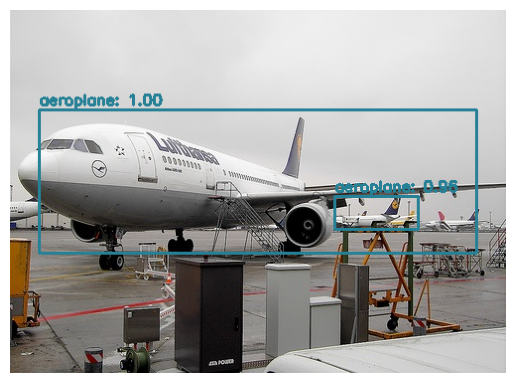

Accuracy: 0.6666666666666666
Confusion Matrix:
 [[0 0]
 [1 2]]


In [23]:
# Load YOLOv3 model
net = cv2.dnn.readNet("yolov3.weights", "yolov3.cfg")

labels = ['person', 'bicycle', 'car', 'motorbike', 'aeroplane', 'bus', 'train', 'truck', 'boat', 'traffic light',
          'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
          'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee',
          'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard',
          'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
          'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'sofa', 'pottedplant',
          'bed', 'diningtable', 'toilet', 'tvmonitor', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave',
          'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier',
          'toothbrush']

# Function to get bounding boxes and detected classes
def get_objects(image):
    height, width, _ = image.shape

    # Preprocess the image for YOLO
    blob = cv2.dnn.blobFromImage(image, 1/255.0, (416, 416), swapRB=True, crop=False)
    net.setInput(blob)

    # Get output layers
    output_layers_names = net.getUnconnectedOutLayersNames()
    layer_outputs = net.forward(output_layers_names)

    boxes = []
    confidences = []
    class_ids = []

    for output in layer_outputs:
        for detection in output:
            scores = detection[5:]
            class_id = np.argmax(scores)
            confidence = scores[class_id]
            if confidence > 0.5:
                center_x, center_y, w, h = (detection[0:4] * np.array([width, height, width, height])).astype(int)
                x, y = int(center_x - w/2), int(center_y - h/2)
                boxes.append([x, y, int(w), int(h)])
                confidences.append(float(confidence))
                class_ids.append(class_id)

    return boxes, confidences, class_ids

# Function to draw bounding boxes on the image
def draw_boxes(image, boxes, confidences, class_ids):
    colors = np.random.uniform(0, 255, size=(len(labels), 3))

    for i in range(len(boxes)):
        x, y, w, h = boxes[i]
        label = f"{labels[class_ids[i]]}: {confidences[i]:.2f}"
        color = colors[class_ids[i]]
        cv2.rectangle(image, (x, y), (x + w, y + h), color, 2)
        cv2.putText(image, label, (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)


#TODO: meter esto en un bucle con todas las imagenes
# Load the input image
image = cv2.imread("2007_000033.jpg")
testLabels = ['aeroplane', 'aeroplane', 'aeroplane'] #TODO: cambiar luego con los reales, esto es de prueba para el accuracy
predicted_labels = [''] * len(testLabels)

# Get bounding boxes and detected classes
boxes, confidences, class_ids = get_objects(image)

# Apply non-maximum suppression
indices = cv2.dnn.NMSBoxes(boxes, confidences, score_threshold=0.5, nms_threshold=0.4)

# Filter the bounding boxes, confidences, and class IDs
boxes = [boxes[i] for i in indices.flatten()]
confidences = [confidences[i] for i in indices.flatten()]
class_ids = [class_ids[i] for i in indices.flatten()]

# Get the predicted labels
for i in range(len(class_ids)):
    predicted_labels[i] = labels[class_ids[i]]

# Draw bounding boxes on the image
draw_boxes(image, boxes, confidences, class_ids)

# Show the resulting image with Matplotlib
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

# Calculate accuracy and other metrics
accuracy = accuracy_score(testLabels, predicted_labels)
confusion_mat = confusion_matrix(testLabels, predicted_labels)

# Print the metrics
print(f"Accuracy: {accuracy}")
print("Confusion Matrix:\n", confusion_mat)
